**This notebook is an exercise in the [Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/alexisbcook/pipelines).**

---


In this exercise, you will use **pipelines** to improve the efficiency of your machine learning code.

# Setup

The questions below will give you feedback on your work. Run the following cell to set up the feedback system.

In [1]:
# Set up code checking
import os
if not os.path.exists("../input/train.csv"):
    os.symlink("../input/home-data-for-ml-course/train.csv", "../input/train.csv")  
    os.symlink("../input/home-data-for-ml-course/test.csv", "../input/test.csv") 
from learntools.core import binder
binder.bind(globals())
from learntools.ml_intermediate.ex4 import *
print("Setup Complete")
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

Setup Complete


You will work with data from the [Housing Prices Competition for Kaggle Learn Users](https://www.kaggle.com/c/home-data-for-ml-course). 

![Ames Housing dataset image](https://i.imgur.com/lTJVG4e.png)

Run the next code cell without changes to load the training and validation sets in `X_train`, `X_valid`, `y_train`, and `y_valid`.  The test set is loaded in `X_test`.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X_full = pd.read_csv('../input/train.csv', index_col='Id')
X_test_full = pd.read_csv('../input/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)
## trying new data 
x2=X_train_full.copy()
xnew = x2.drop(['Alley','PoolQC','MiscFeature','Fence',],axis=1)



# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in xnew.columns if
                    xnew[cname].nunique() < 10 and 
                    xnew[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in xnew.columns if 
                xnew[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = xnew[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

In [3]:
X_train.head()


,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,BldgType,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
619,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,...,774,0,108,0,0,260,0,0,7,2007
871,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,PosN,Norm,1Fam,...,308,0,0,0,0,0,0,0,8,2009
93,RL,Pave,IR1,HLS,AllPub,Inside,Gtl,Norm,Norm,1Fam,...,432,0,0,44,0,0,0,0,8,2009
818,RL,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Norm,Norm,1Fam,...,857,150,59,0,0,0,0,0,7,2008
303,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,...,843,468,81,0,0,0,0,0,1,2006


In [4]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Data columns (total 72 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       1455 non-null   object 
 1   Street         1459 non-null   object 
 2   LotShape       1459 non-null   object 
 3   LandContour    1459 non-null   object 
 4   Utilities      1457 non-null   object 
 5   LotConfig      1459 non-null   object 
 6   LandSlope      1459 non-null   object 
 7   Condition1     1459 non-null   object 
 8   Condition2     1459 non-null   object 
 9   BldgType       1459 non-null   object 
 10  HouseStyle     1459 non-null   object 
 11  RoofStyle      1459 non-null   object 
 12  RoofMatl       1459 non-null   object 
 13  MasVnrType     1443 non-null   object 
 14  ExterQual      1459 non-null   object 
 15  ExterCond      1459 non-null   object 
 16  Foundation     1459 non-null   object 
 17  BsmtQual       1415 non-null   object 
 18  BsmtC

In [5]:
# x2=X_train.copy()
# xnew = x2.drop(['Alley','PoolQC','MiscFeature','Fence','FireplaceQu'],axis=1)
# xnew.info()

The next code cell uses code from the tutorial to preprocess the data and train a model.  Run this code without changes.

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_valid)


print('MAE:', mean_absolute_error(y_valid, preds))

MAE: 17601.65037671233


The code yields a value around 17862 for the mean absolute error (MAE).  In the next step, you will amend the code to do better.

# Step 1: Improve the performance

### Part A

Now, it's your turn!  In the code cell below, define your own preprocessing steps and random forest model.  Fill in values for the following variables:
- `numerical_transformer`
- `categorical_transformer`
- `model`

To pass this part of the exercise, you need only define valid preprocessing steps and a random forest model.

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

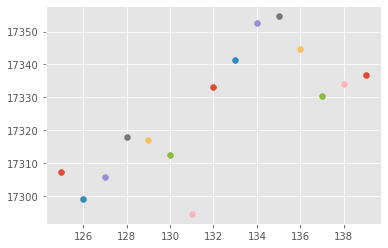

In [7]:
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
forest_acc =[]
for i in range (125 , 140):
    model = RandomForestRegressor(n_estimators=i, random_state=0)
    

# Bundle preprocessing and modeling code in a pipeline
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
    clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
    preds = clf.predict(X_valid)
    MEA = mean_absolute_error(y_valid, preds)  
    forest_acc.append(MEA)
    plt.scatter(i ,MEA )
    forest_acc.clear()

# Check your answer




step_1.a.check()

In [8]:
# Lines below will give you a hint or solution code
step_1.a.hint()
step_1.a.solution()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> While there are many different potential solutions to this problem, we achieved satisfactory results by changing only `column_transformer` from the default value - specifically, we changed the `strategy` parameter that decides how missing values are imputed.

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0)

```

### Part B

Run the code cell below without changes.

To pass this step, you need to have defined a pipeline in **Part A** that achieves lower MAE than the code above.  You're encouraged to take your time here and try out many different approaches, to see how low you can get the MAE!  (_If your code does not pass, please amend the preprocessing steps and model in Part A._)

In [9]:
# Bundle preprocessing and modeling code in a pipeline
model = RandomForestRegressor(n_estimators=131, random_state=0)
    

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
#preds = clf.predict(X_valid)
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

# Check your answer
step_1.b.check()

MAE: 17294.58857053226


<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [10]:
# Line below will give you a hint
#step_1.b.hint()

# Step 2: Generate test predictions

Now, you'll use your trained model to generate predictions with the test data.

In [11]:
# Preprocessing of test data, fit model
preds_test = my_pipeline.predict(X_test) # Your code here
#score = mean_absolute_error(y, preds_test)
# Check your answer
step_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [12]:
# Lines below will give you a hint or solution code
#step_2.hint()
#step_2.solution()

Run the next code cell without changes to save your results to a CSV file that can be submitted directly to the competition.

In [13]:
# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

# Submit your results

Once you have successfully completed Step 2, you're ready to submit your results to the leaderboard!  If you choose to do so, make sure that you have already joined the competition by clicking on the **Join Competition** button at [this link](https://www.kaggle.com/c/home-data-for-ml-course).  
1. Begin by clicking on the **Save Version** button in the top right corner of the window.  This will generate a pop-up window.  
2. Ensure that the **Save and Run All** option is selected, and then click on the **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

If you want to keep working to improve your performance, select the **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.


# Keep going

Move on to learn about [**cross-validation**](https://www.kaggle.com/alexisbcook/cross-validation), a technique you can use to obtain more accurate estimates of model performance!

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/intermediate-machine-learning/discussion) to chat with other learners.*